In [2]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX

# NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Maps (lightweight, NO geopandas)
import folium

# Utils
import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")


In [3]:
# data laoding
train = pd.read_csv("train.csv.csv")
test = pd.read_csv("test.csv.csv")
comments = pd.read_csv("nasa_comments.csv")

train.head()


,latitude,longitude,year,week_no,SO2_density,NO2_density,CO_density,aerosol_index,emission
0,-0.951451,29.867752,2021,29,1.062943,0.231685,1.353632,0.394479,42.227483
1,-0.821294,29.582765,2019,28,1.538561,3.632084,4.673384,1.331891,76.805868
2,-0.381890,30.161250,2021,25,4.185753,1.488805,0.953174,0.957397,82.030073
3,-0.287141,29.193945,2021,18,2.934490,2.461517,5.716684,0.294930,28.928609
4,-0.997785,29.655822,2019,25,0.072652,1.225602,1.426778,2.175967,90.882709


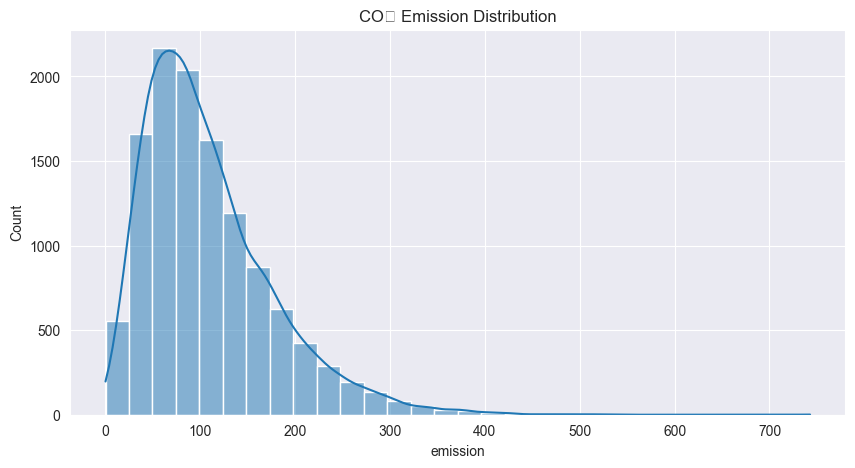

np.float64(1.3088831745630276)

In [4]:
# 4.1 Emission Distribution
plt.figure(figsize=(10,5))
sns.histplot(train["emission"], bins=30, kde=True)
plt.title("CO₂ Emission Distribution")
plt.show()

train["emission"].skew()


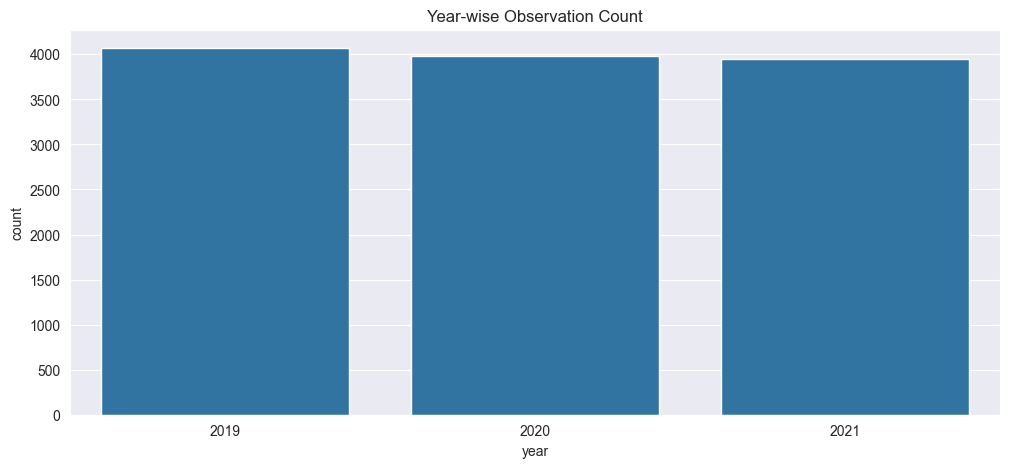

In [5]:
# Temporal Patterns
plt.figure(figsize=(12,5))
sns.countplot(x="year", data=train)
plt.title("Year-wise Observation Count")
plt.show()


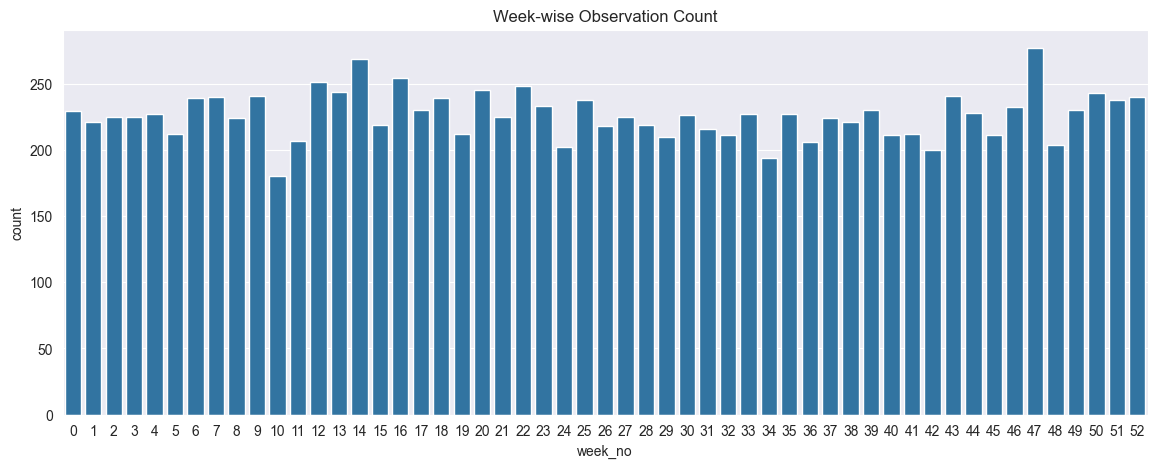

In [6]:
plt.figure(figsize=(14,5))
sns.countplot(x="week_no", data=train)
plt.title("Week-wise Observation Count")
plt.show()


In [7]:
# Drop extremely high-missing columns if any
missing_ratio = train.isna().mean()
train = train.drop(columns=missing_ratio[missing_ratio > 0.9].index)
test = test.drop(columns=missing_ratio[missing_ratio > 0.9].index)


In [14]:
# Median imputation
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)


,latitude,longitude,year,week_no,SO2_density,NO2_density,CO_density,aerosol_index
0,-0.911158,29.817499,2022,4,0.526694,3.091154,2.046241,2.059732
1,-0.378837,29.538679,2022,44,3.973748,0.449094,2.929983,1.883041
2,-0.981061,30.435564,2022,50,4.608647,3.633648,3.808493,2.512508
3,-0.300479,29.320575,2022,50,0.352577,2.881619,0.072517,2.041630
4,-0.891715,30.088564,2022,36,0.472698,1.004861,5.736020,2.258744
...,...,...,...,...,...,...,...,...
3995,-0.813845,29.833668,2022,46,4.337280,3.699066,5.768003,2.789472
3996,-0.588738,29.806265,2022,8,4.748994,2.972377,1.272984,2.977741
3997,-0.564247,30.445548,2022,28,1.768798,0.581150,0.317019,0.370039
3998,-0.329857,29.516200,2022,16,4.095510,3.151907,0.251198,1.677916


In [8]:
# Log-transform target
train["emission_log"] = np.log1p(train["emission"])


In [10]:
train["lat_round"] = train["latitude"].round(2)
train["lon_round"] = train["longitude"].round(2)


In [11]:
import numpy as np

def safe_trend(y):
    y = np.asarray(y)
    y = y[np.isfinite(y)]

    if len(y) < 2:
        return 0.0

    try:
        x = np.arange(len(y))
        return np.polyfit(x, y, 1)[0]
    except Exception:
        return 0.0


location_features = train.groupby(
    ["lat_round", "lon_round"]
).agg(
    mean_emission=("emission", "mean"),
    std_emission=("emission", "std"),
    max_emission=("emission", "max"),
    trend=("emission", safe_trend)
).reset_index()

location_features.fillna(0, inplace=True)
location_features.head()



,lat_round,lon_round,mean_emission,std_emission,max_emission,trend
0,-1.2,29.03,43.446334,0.0,43.446334,0.0
1,-1.2,29.04,47.446522,0.0,47.446522,0.0
2,-1.2,29.05,122.846211,0.0,122.846211,0.0
3,-1.2,29.06,148.271135,0.0,148.271135,0.0
4,-1.2,29.12,150.062204,0.0,150.062204,0.0


In [12]:
X = location_features[
    ["mean_emission", "std_emission", "trend"]
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
location_features["risk_zone"] = kmeans.fit_predict(X_scaled)


In [13]:
risk_map = {0: "Low Risk", 1: "Medium Risk", 2: "High Risk"}
location_features["risk_label"] = location_features["risk_zone"].map(risk_map)


In [ ]:
m = folium.Map(
    location=[
        location_features.lat_round.mean(),
        location_features.lon_round.mean()
    ],
    zoom_start=7
)

colors = {"Low Risk": "green", "Medium Risk": "orange", "High Risk": "red"}

for _, row in location_features.iterrows():
    folium.CircleMarker(
        location=[row.lat_round, row.lon_round],
        radius=5,
        color=colors[row.risk_label],
        fill=True,
        fill_opacity=0.7,
        popup=f"Risk: {row.risk_label}"
    ).add_to(m)

m
